In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import  ncx2
import pandas as pd
from numba import  njit

In [2]:
class StochasticProcess:
    def __init__(self, params, T, Nx, Nt, init_state = None):
        self.params = params
        self.T = T
        self.Nx = Nx # Number of trajectories
        self.Nt = Nt # Number of discretization steps
        self.init_state = init_state

    #Wiener Process by default
    #use @staticmethod for numba compatibility with @njit
    @staticmethod
    @njit
    def bxt(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return 1

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def bxt_t(x, t, params):
        return 0

    def DefaultInitState(self):
        return np.zeros(self.Nx)

    def EulerSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx), dtype=np.float64)

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt+1, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state
    
        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + self.bxt(x_data[i - 1], t_data[i - 1], self.params) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]
        return t_data, x_data

    def Milstein2Solution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        for i in range(1, self.Nt + 1):
            x_data[i] = x_data[i - 1] + (self.bxt(x_data[i - 1], t_data[i - 1], self.params) - 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params)) * dt +\
                        self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1] + 1/2 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) * dwt[i - 1]**2 +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/2 * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params) +\
                        1/4 * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2 * self.sigmaxt_xx(x_data[i - 1], t_data[i - 1], self.params)) * dt * dwt[i - 1] +\
                        (1/2 * self.bxt(x_data[i - 1], t_data[i - 1], self.params) * self.bxt_x(x_data[i - 1], t_data[i - 1], self.params) + 1/4 * self.bxt_xx(x_data[i - 1], t_data[i - 1], self.params) * self.sigmaxt(x_data[i - 1], t_data[i - 1], self.params)**2) * dt**2
        return t_data, x_data


class CIRprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] - params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return -params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * 1/2 * 1/np.sqrt(np.maximum(x,0))

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return -params[2] * 1/4 * 1/np.maximum(x,0)**(3/2)

    def DefaultInitState(self):
        return self.params[0] / self.params[1] * np.ones(self.Nx)

    def ExactSolution(self, dwt = None):
        dt = self.T / self.Nt
        t_data = np.linspace(0, self.T, self.Nt + 1)
        x_data = np.zeros((self.Nt + 1, self.Nx))

        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        if self.init_state is None:
            x_data[0] = self.DefaultInitState()
        else:
            x_data[0] = self.init_state

        if dwt is None:
            dwt = np.random.normal(0, 1, size = (self.Nt, self.Nx)) * np.sqrt(dt)

        Ito_integral_sum = np.zeros(self.Nx)
        for i in range(1, self.Nt + 1):
            Determinated_part = (x_data[0] - theta1 / theta2) * np.exp(-theta2 * t_data[i]) + theta1/theta2
            #avoiding exp overflow
            Ito_integral_sum = (Ito_integral_sum + theta3 * np.sqrt(np.maximum(x_data[i - 1], 0)) * dwt[i - 1]) * np.exp(-theta2 * dt)
            x_data[i] = Determinated_part + Ito_integral_sum
        return t_data, x_data

    def StationaryState(self):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1

        return ncx2.rvs(2 * q + 2, 2 * u, size = self.Nx) / (2 * c)

    def ProcessDistribution(self, x, t, x0, t0):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2 * (1 - np.exp(-k * (t - t0))))
        u = c * x0 * np.exp(-k * (t - t0))
        #v = c * x
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c) #2c is normalazing constant

    def StationaryDistribution(self, x):
        theta1 = self.params[0]
        theta2 = self.params[1]
        theta3 = self.params[2]

        k = theta2
        theta = theta1 / theta2
        sigma = theta3

        c = 2 * k / (sigma**2)
        u = 0
        q = 2 * k * theta / sigma**2 - 1
        return ncx2.pdf(2 * c * x, 2 * q + 2, 2 * u) * (2 * c)

Task 1. Simulate a Cox-Ingersoll-Ross (CIR) model
$$
dX_t = (\theta_1 - \theta_2 X_t)dt + \theta_3 \sqrt{X_t}dW_t
$$
with $\theta = (6, 2, 1)$, and choose the bandwidth according to Scott’s rule and implement the non-parametric kernel estimation for stationary density of the CIR model.

Plot in a graph the true stationary density against the estimated one for two approaches
*  compute on the single trajectory  (set $T$ very large, time discretization step set as $T/N_t = \Delta t$);
*  compute on the Nx trajectories.




In [3]:
def StationaryDistributionKernelEstimator(x, x_data, delta = None):
    n = len(x_data)
    m = 1

    hn = 1

    if delta is None:
        hn = np.std(x_data) * n**(-1 / (m + 4))
    else:
        hn = delta

    pi = np.zeros(len(x))

    for j in range(0, len(x)):
        K = 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * (x[j] - x_data)**2 / hn**2)

        pi[j] = 1 / (n * hn) * np.sum(K)

    return pi

In [13]:
# approach 1

Nx = 1
Nt = 100000
T = 1000

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

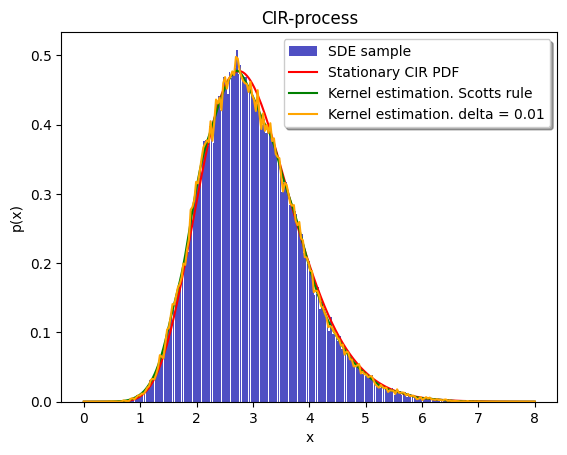

In [5]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR.flatten(), bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process', loc = 'center')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten()), label = f'Kernel estimation. Scotts rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR.flatten(), delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [6]:
# approach 2

Nx = 15000
Nt = 300

T = 1

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
CIRp.init_state = CIRp.StationaryState()
t_data, x_data_CIR = CIRp.ExactSolution()

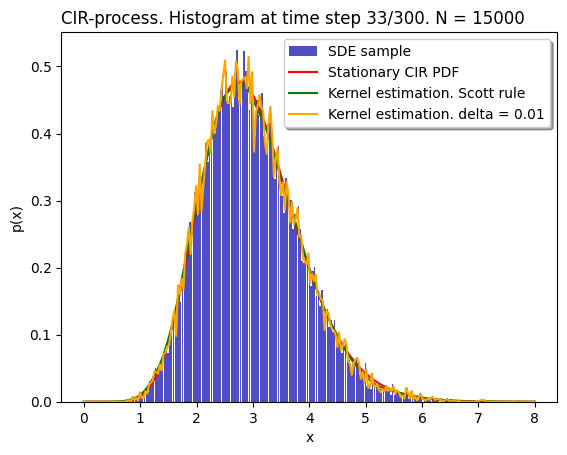

In [7]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CIR[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CIR-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, CIRp.StationaryDistribution(x_data), label = 'Stationary CIR PDF', color = 'red')
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

Task. Estimate the quality of the obtained approximations with statistical criteria and provide conclusions.

1. Критерий Колмогорова-Смирнова

Проверяет, принадлежат ли две выборки к одному и тому же распределению. Если p-значение меньше заданного уровня значимости, гипотеза о схожести распределений отвергается.

In [8]:
stationary_CIR_PDF = CIRp.StationaryDistribution(x_data)
stationary_kernel_est_Scott_rule = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i])
stationary_kernel_est_delta = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta = d)

In [9]:
from scipy.stats import ks_2samp

KS_stat_Scott, KS_p_value_Scott = ks_2samp(stationary_CIR_PDF, stationary_kernel_est_Scott_rule)
print(f"Kolmogorov-Smirnov test for PDF and Scott Rule: statistic={KS_stat_Scott}, p-value={KS_p_value_Scott}")

KS_stat_Delta, KS_p_value_Delta = ks_2samp(stationary_CIR_PDF, stationary_kernel_est_delta)
print(f"Kolmogorov-Smirnov test for PDF and Kernel with Delta: statistic={KS_stat_Delta}, p-value={KS_p_value_Delta}")


Kolmogorov-Smirnov test for PDF and Scott Rule: statistic=0.024, p-value=0.999999722968034
Kolmogorov-Smirnov test for PDF and Kernel with Delta: statistic=0.196, p-value=0.00012925171075981644


2. Критерий Крамера-Мизеса

Проверяет степень отклонения между двумя функциями распределения, является усиленной версией теста Колмогорова-Смирнова. Более чувствителен к отличиям в хвостах распределений, чем тест Колмогорова-Смирнова.

In [10]:
from scipy.stats import cramervonmises_2samp

CM_result_Scott = cramervonmises_2samp(stationary_CIR_PDF, stationary_kernel_est_Scott_rule)
print(f"Cramer-von Mises test for PDF and Scott Rule: statistic={CM_result_Scott.statistic}, p-value={CM_result_Scott.pvalue}")

CM_result_Delta = cramervonmises_2samp(stationary_CIR_PDF, stationary_kernel_est_delta)
print(f"Cramer-von Mises test for PDF and Kernel with Delta: statistic={CM_result_Delta.statistic}, p-value={CM_result_Delta.pvalue}")


Cramer-von Mises test for PDF and Scott Rule: statistic=0.006472000000002254, p-value=0.9999999986907788
Cramer-von Mises test for PDF and Kernel with Delta: statistic=0.48924399999999935, p-value=0.04242497594646477


3. Расстояние Кульбака-Лейблера (KL-дивергенция)

Измеряет степень расхождения одного распределения от другого. Чем меньше KL-дивергенция, тем ближе распределения друг к другу.

In [11]:
from scipy.stats import entropy

kl_divergence_Scott = entropy(stationary_CIR_PDF, stationary_kernel_est_Scott_rule)
print(f"KL Divergence D(PDF || Scott Rule): {kl_divergence_Scott}")

kl_divergence_Delta = entropy(stationary_CIR_PDF, stationary_kernel_est_delta)
print(f"KL Divergence D(PDF || Delta fixed): {kl_divergence_Delta}")


KL Divergence D(PDF || Scott Rule): 0.0006418789559730549
KL Divergence D(PDF || Delta fixed): inf


4. Критерий Манна-Уитни (U-тест)

Сравнивает медианы двух выборок и проверяет, принадлежат ли выборки одному распределению. Применяется для проверки гипотезы о схожести распределений, если распределения сдвинуты относительно друг друга.

In [12]:
from scipy.stats import mannwhitneyu

MW_stat_Scott, MW_p_value_Scott = mannwhitneyu(stationary_CIR_PDF,stationary_kernel_est_Scott_rule, alternative='two-sided')
print(f"Mann-Whitney U test for PDF and Scott Rule: statistic={MW_stat_Scott}, p-value={MW_p_value_Scott}")

MW_stat_Delta, MW_p_value_Delta = mannwhitneyu(stationary_CIR_PDF,stationary_kernel_est_delta, alternative='two-sided')
print(f"Mann-Whitney U test for PDF and Delta fixed: statistic={MW_stat_Delta}, p-value={MW_p_value_Delta}")


Mann-Whitney U test for PDF and Scott Rule: statistic=31230.0, p-value=0.9903684568094914
Mann-Whitney U test for PDF and Delta fixed: statistic=33063.5, p-value=0.2617070785833109


5. Критерий Вилкоксона

Непараметрический тест, проверяющий, идентичны ли центральные значения двух выборок. Позволяет оценить схожесть, особенно если данные симметрично распределены.


In [13]:
from scipy.stats import wilcoxon

W_stat_Scott, W_p_value_Scott = wilcoxon(stationary_CIR_PDF, stationary_kernel_est_Scott_rule)
print(f"Wilcoxon test for PDF and Scott Rule: statistic={W_stat_Scott}, p-value={W_p_value_Scott}")

W_stat_Delta, W_p_value_Delta = wilcoxon(stationary_CIR_PDF, stationary_kernel_est_delta)
print(f"Wilcoxon test for PDF and Delta Fixed: statistic={W_stat_Delta}, p-value={W_p_value_Delta}")


Wilcoxon test for PDF and Scott Rule: statistic=15193.0, p-value=0.6656962674494179
Wilcoxon test for PDF and Delta Fixed: statistic=14864.0, p-value=0.5392305463635919


In [14]:
df = pd.DataFrame([['Kolmogorov-Smirnov', 'Cramer von Mises', 'Mann-Whitney', 'Wilcoxon'],
              [KS_stat_Scott, CM_result_Scott.statistic, MW_stat_Scott, W_stat_Scott],
              [KS_p_value_Scott, CM_result_Scott.pvalue, MW_p_value_Scott, W_p_value_Scott],
              [KS_stat_Delta, CM_result_Delta.statistic, MW_stat_Delta, W_stat_Delta],
              [KS_p_value_Delta, CM_result_Delta.pvalue, MW_p_value_Delta, W_p_value_Delta]]).T

df.columns = ['criteria', 'statistic_Scott', 'p_value_Scott', 'statistic_Delta', 'p_value_Delta']
df.set_index('criteria')
df

,criteria,statistic_Scott,p_value_Scott,statistic_Delta,p_value_Delta
0,Kolmogorov-Smirnov,0.024,1.0,0.196,0.000129
1,Cramer von Mises,0.006472,1.0,0.489244,0.042425
2,Mann-Whitney,31230.0,0.990368,33063.5,0.261707
3,Wilcoxon,15193.0,0.665696,14864.0,0.539231


In [15]:
print(f"Scott KL divergence: {kl_divergence_Scott}\nDelta KL divergence: {kl_divergence_Delta}")

Scott KL divergence: 0.0006418789559730549
Delta KL divergence: inf


Видим, что критерий Скотта дает наилучшую апроксимацию распределения

Task. Study the effect of the bandwidth $h_n$ and the mesh $∆_n$ on the kernel estimator and plot a 3D graph.

100%|██████████| 58/58 [00:15<00:00,  3.75it/s]


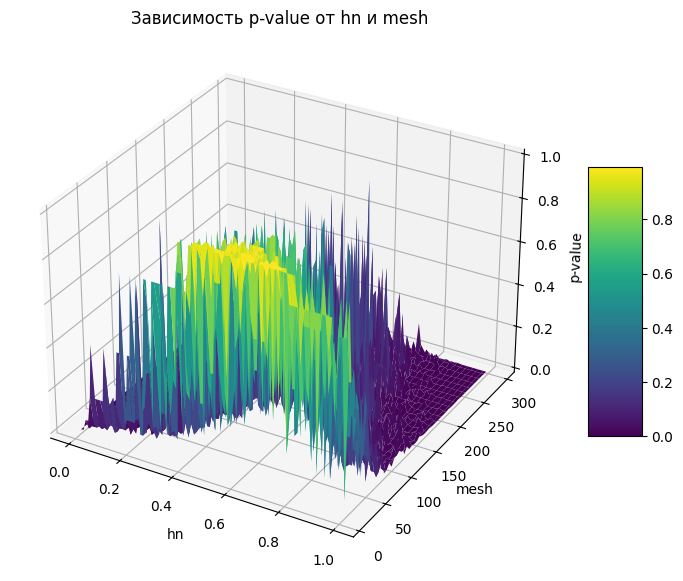

In [16]:
from tqdm import tqdm
# approach 2

Nx = 30
Nt = 300

np.random.seed(42)
i = np.random.randint(0, Nt)

meshes = [i for i in range(10, 300, 5)] 

hns = np.linspace(0.0001, 1, 100)

p_values = []


T = 1

params_CIR = [6, 2, 1]

for mesh in tqdm(meshes):
    row = []
    for hn in hns:
        x_data = np.linspace(0, 8, mesh)
        CIRp = CIRprocess(params_CIR, T, Nx, Nt)
        t_data, x_data_CIR = CIRp.ExactSolution()

        delta_fixed = StationaryDistributionKernelEstimator(x_data, x_data_CIR[i], delta=hn)
        stationary_CIR_PDF = CIRp.StationaryDistribution(x_data)

        stat, p_value = ks_2samp(stationary_CIR_PDF, delta_fixed)
        row.append(p_value)
    p_values.append(row)


# Преобразуем p_values в массив numpy
p_values = np.array(p_values)

# Построение 3D-графика
X, Y = np.meshgrid(hns, meshes)
Z = p_values

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Рисуем поверхность
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Подписи
ax.set_xlabel('hn')
ax.set_ylabel('mesh')
ax.set_zlabel('p-value')
ax.set_title('Зависимость p-value от hn и mesh')

plt.show()

        

Task. Repeat previos tasks on the Chan-Karolyi-Longstaff-Sanders (CKLS) model
\begin{equation*}%\label{eq09}
 dX_{t} = (\theta_{1}+\theta_{2} X_{t}) dt + \theta_{3} X_{t}^{\theta_{4}} dW_{t},\qquad X_{0}=2
\end{equation*}
with $\theta_{1}=1$, $\theta_{2}=2$, $\theta_{3}=0.5$, $\theta_{4}=0.3$.

In [7]:
from scipy.stats import gaussian_kde

class CKLSprocess(StochasticProcess):
    def __init__(self, params, T, Nx, Nt, init_state = None):
        super().__init__(params, T, Nx, Nt, init_state)

    # params = [theta1, theta2, theta3, theta4]
    @staticmethod
    @njit
    def bxt(x, t, params):
        return params[0] + params[1] * x

    @staticmethod
    @njit
    def sigmaxt(x, t, params):
        return params[2] * (x ** params[3])

    @staticmethod
    @njit
    def bxt_x(x, t, params):
        return params[1]

    @staticmethod
    @njit
    def sigmaxt_x(x, t, params):
        return params[2] * params[3] * x ** (params[3] - 1)
    
    @staticmethod
    @njit
    def bxt_xx(x, t, params):
        return 0

    @staticmethod
    @njit
    def sigmaxt_xx(x, t, params):
        return params[2] * params[3] * (params[3] - 1) * x ** (params[3] - 2)
    
    def DefaultInitState(self):
        return  - self.params[0] / self.params[1] * np.ones(self.Nx, dtype=np.float64)

    def ExactSolution(self, dwt = None):
        pass

    def StationaryState(self):
        pass

    def ProcessDistribution(self, x, t, x0, t0):
        pass



In [5]:
# approach 2

Nx = 1000
Nt = 300

T = 1

params_CKLS = [1., 2., 0.5, 0.3]

CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
# CKLS.init_state = CKLS.DefaultInitState()
CKLS.init_state = 2 * np.ones(Nx, dtype=np.float64)
t_data, x_data_CKLS = CKLS.EulerSolution()

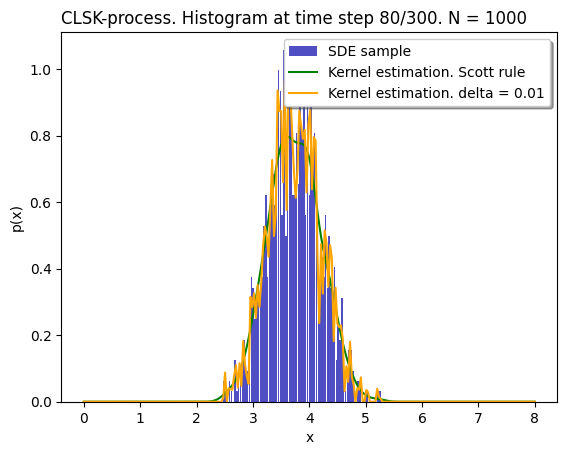

In [8]:
n = np.random.randint(0, Nt)
fig, ax = plt.subplots()
x_data = np.linspace(0, 8, 250)

np.random.seed(41)
i = np.random.randint(0, Nt)

n, bins, patches = ax.hist(x_data_CKLS[i], bins=x_data, density=True, color='#0504aa', alpha=0.7, rwidth=0.85, label = 'SDE sample')
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
ax.set_title(f'CLSK-process. Histogram at time step {i}/{Nt}. N = {Nx}', loc = 'left')

ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i]), label = f'Kernel estimation. Scott rule', color = 'green')

d = 0.01
ax.plot(x_data, StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d),
        label = f'Kernel estimation. delta = {d}', color = 'orange')

ax.legend(loc = 'upper right', fancybox = True, shadow = True)
plt.show()

In [10]:
CKLS_Scott = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i])
CKLS_Delta = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = d)

In [11]:
from scipy.stats import ks_2samp
from scipy.stats import cramervonmises_2samp
from scipy.stats import entropy
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon

KS_stat_Scott_vs_Delta, KS_p_value_Scott_vs_Delta = ks_2samp(CKLS_Scott, CKLS_Delta)
print(f"Kolmogorov-Smirnov test for PDF and Scott Rule: statistic={KS_stat_Scott_vs_Delta},\
       p-value={KS_p_value_Scott_vs_Delta}")

CM_result_Scott_vs_Delta = cramervonmises_2samp(CKLS_Scott, CKLS_Delta)
print(f"Cramer-von Mises test for PDF and Scott Rule: statistic={CM_result_Scott_vs_Delta.statistic},\
       p-value={CM_result_Scott_vs_Delta.pvalue}")

kl_divergence_Scott_vs_Delta = entropy(CKLS_Scott, CKLS_Delta)
print(f"KL Divergence D(PDF || Scott Rule): {kl_divergence_Scott_vs_Delta}")

MW_stat_Scott_vs_Delta, MW_p_value_Scott_vs_Delta = mannwhitneyu(CKLS_Delta, CKLS_Scott, alternative='two-sided')
print(f"Mann-Whitney U test for PDF and Scott Rule: statistic={MW_stat_Scott_vs_Delta},\
       p-value={MW_p_value_Scott_vs_Delta}")

W_stat_Scott_vs_Delta, W_p_value_Scott_vs_Delta = wilcoxon(CKLS_Scott, CKLS_Delta)
print(f"Wilcoxon test for PDF and Scott Rule: statistic={W_stat_Scott_vs_Delta}, p-value={W_p_value_Scott_vs_Delta}")



Kolmogorov-Smirnov test for PDF and Scott Rule: statistic=0.6,       p-value=3.497719305908141e-42
Cramer-von Mises test for PDF and Scott Rule: statistic=11.684799999999996,       p-value=7.015360514728286e-10
KL Divergence D(PDF || Scott Rule): inf
Mann-Whitney U test for PDF and Scott Rule: statistic=18765.0,       p-value=5.50132352826467e-15
Wilcoxon test for PDF and Scott Rule: statistic=8739.0, p-value=1.269975876026852e-09


In [16]:
df = pd.DataFrame([['Kolmogorov-Smirnov', KS_stat_Scott_vs_Delta, KS_p_value_Scott_vs_Delta],
                   ['Cramer von Mises', CM_result_Scott_vs_Delta.statistic, CM_result_Scott_vs_Delta.pvalue],
                   ['Mann-Whitney', MW_stat_Scott_vs_Delta, MW_p_value_Scott_vs_Delta],
                   ['Wilcoxon', W_stat_Scott_vs_Delta, W_p_value_Scott_vs_Delta]],
                   columns=['criteria', 'statistic', 'p_value'])

df.set_index('criteria')

,statistic,p_value
criteria,,
Kolmogorov-Smirnov,0.6000,3.497719e-42
Cramer von Mises,11.6848,7.015361e-10
Mann-Whitney,18765.0000,5.501324e-15
Wilcoxon,8739.0000,1.269976e-09


In [17]:
kl_divergence_Scott_vs_Delta

inf

100%|██████████| 58/58 [00:33<00:00,  1.75it/s]


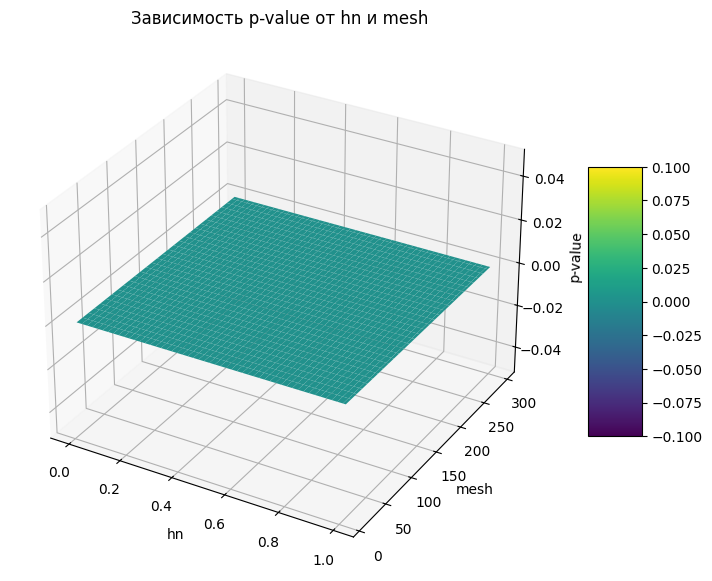

In [107]:
from tqdm import tqdm
# approach 2

Nx = 100
Nt = 300

np.random.seed(41)
i = np.random.randint(0, Nt)

meshes = [i for i in range(10, 300, 5)] 

hns = np.linspace(0.0001, 1, 100)

p_values = []


T = 1

params_CKLS = [1., 2., 0.5, 0.3]


for mesh in tqdm(meshes):
    row = []
    for hn in hns:
        x_data = np.linspace(0, 8, mesh)
        # np.random.seed(41)
        i = np.random.randint(30, 100)
        CKLS = CKLSprocess(params_CKLS, T, Nx, Nt)
        t_data, x_data_CKLS = CKLS.EulerSolution()

        Scott_fixed = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i])
        delta_dist = StationaryDistributionKernelEstimator(x_data, x_data_CKLS[i], delta = hn)

        # stat, p_value = ks_2samp(Scott_fixed, delta_dist)
        res = cramervonmises_2samp(Scott_fixed, delta_dist)
        stat, p_value = res.statistic, res.pvalue
        # cramervonmises_2samp
        row.append(p_value)
    p_values.append(row)


# Преобразуем p_values в массив numpy
p_values = np.array(p_values)

# Построение 3D-графика
X, Y = np.meshgrid(hns, meshes)
Z = p_values

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Рисуем поверхность
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Подписи
ax.set_xlabel('hn')
ax.set_ylabel('mesh')
ax.set_zlabel('p-value')
ax.set_title('Зависимость p-value от hn и mesh')

plt.show()

Task 2. Implement a non-parametric drift estimator

$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}
$$

and diffusion estimator
$$
\hat{\sigma}^2_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)^2} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)}.$$


for the CIR model (Task 1) and plot two graphs.
Use the Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$.


In [26]:
from typing import Literal

def NormalKernel(z):
    return 1/np.sqrt(2 * np.pi) * np.exp(-1/2 * z**2)

def UniformKernel(z):
    return 1/2 * np.ones_like(z)

def ParabolicKernel(z):
    return 3/4 * (1 - z**2)

def Gaussian_high_order(z):
    pass

def DiffusionKernelEstimator(x, x_data, delta = None, 
                             method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1])**2)
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

def DriftKernelEstimator(x, x_data, delta = None, 
                         method: Literal['normal', 'uniform', 'parabolic', 'gaussian_high_order'] = 'normal'):
    n = len(x_data)
    m = 1

    hn = 1

    hn = np.std(x_data) * n**(-1 / (m + 4))

    s2 = np.zeros(len(x))

    for j in range(0, len(x)):
        K1 = 0
        K2 = 0
        z = (x[j] - x_data)**2 / hn**2
        if method == 'normal':
            K = NormalKernel(z)
        elif method == 'uniform':
            K = UniformKernel(z)
        elif method == 'parabolic':
            K = ParabolicKernel(z)
        elif method == 'gaussian_high_order':
            K = Gaussian_high_order(z)
        else:
            raise ValueError(f"method = {method} not implemented")

        K1 = np.sum(K[0:n-1] * (x_data[1:] - x_data[0:n-1]))
        K2 = np.sum(K)
        if K2 == 0:
            s2[j] = 0
        else:
            s2[j] = K1 / K2

    if delta is None:
        delta = 1

    return s2 / delta

In [23]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

CIRp = CIRprocess(params_CIR, T, Nx, Nt)
t_data, x_data_CIR = CIRp.ExactSolution()

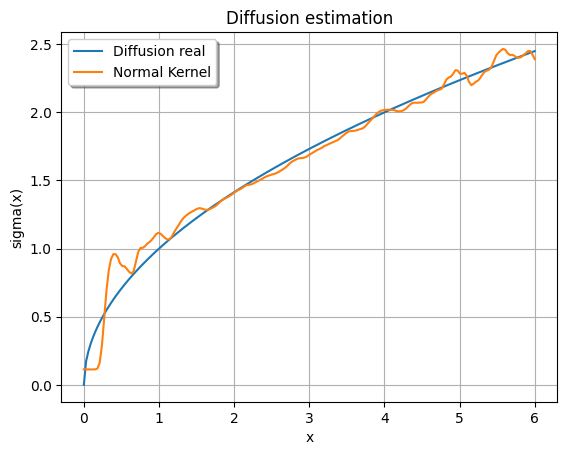

In [24]:
sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')


diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, np.sqrt(diffke), label = 'Parabolic Kernel')

#diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, np.sqrt(diffke), label = 'Uniform Kernel')

plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

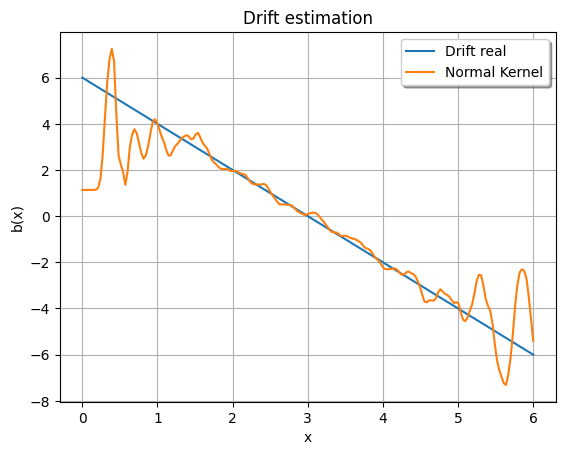

In [32]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
#plt.plot(x_data, driftke, label = 'Parabolic Kernel')

#driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
#plt.plot(x_data, driftke, label = 'Uniform Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()

Task. Implement a non-parametric drift
and diffusion estimators with the higher order Gaussian kernel $K(u)=\frac{3}{\sqrt{8 \pi}}(1-u^2/3)\exp({-u^2/2})$ ([p.24](https://www.nber.org/system/files/working_papers/w5345/w5345.pdf))  and add curves on graphs
for the CIR model.

Improve estimates on the left and the right subintervals $[0,1]$ and $[5,6]$ respectly.


In [56]:
def Gaussian_high_order(z):
    return 3 / np.sqrt(8 * np.pi) * (1 - z**2 / 3) * np.exp(-z**2 / 2)

/var/folders/xx/x_6wt9hs2vq2twldfgptb5840000gn/T/ipykernel_80592/2705930086.py:18: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x_data, np.sqrt(diffke), label = 'Gaussian High Order Kernel')


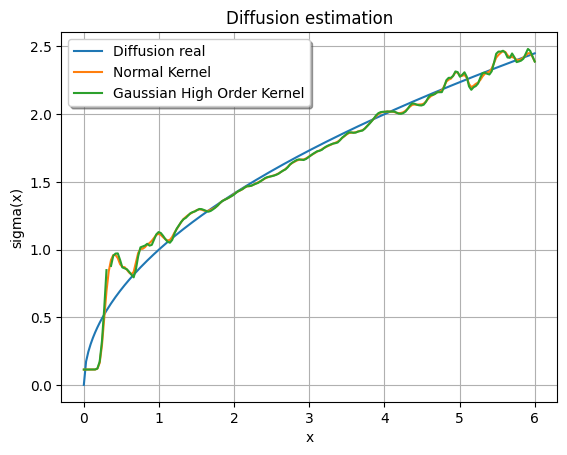

In [75]:
Nx = 1
Nt = 100000

T = 1000

x_data = np.linspace(0, 6, 200)

params_CIR = [6, 2, 1]

sigma_data = CIRp.sigmaxt(x_data, 0, CIRp.params)

plt.plot(x_data, sigma_data, label = 'Diffusion real')

diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, np.sqrt(diffke), label = 'Normal Kernel')

diffke = DiffusionKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'gaussian_high_order')
plt.plot(x_data, np.sqrt(diffke), label = 'Gaussian High Order Kernel')


plt.title("Diffusion estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("sigma(x)")
plt.grid(True)
plt.show()

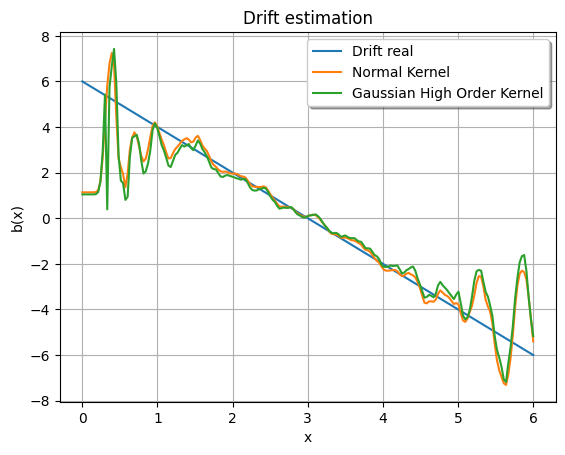

In [104]:
b_data = CIRp.bxt(x_data, 0, CIRp.params)

plt.plot(x_data, b_data, label = 'Drift real')


driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'normal')
plt.plot(x_data, driftke, label = 'Normal Kernel')

# driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'parabolic')
# plt.plot(x_data, driftke, label = 'Parabolic Kernel')

# driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), T/Nt, 'uniform')
# plt.plot(x_data, driftke, label = 'Uniform Kernel')


# from paper https://www.nber.org/system/files/working_papers/w5345/w5345.pdf
# optimal bandwidth = h_n = c_n * n^{-1 / (1 + 2r)} = c_n * n ^ {-1/9}, c_n = c/log(n)
c = .45
hn = c * Nt ** (- 1 / 9) / np.log(Nt)

driftke = DriftKernelEstimator(x_data, x_data_CIR.flatten(), hn, 'gaussian_high_order')
plt.plot(x_data, driftke, label = 'Gaussian High Order Kernel')

plt.title("Drift estimation")
plt.legend(loc = 'best', fancybox = True, shadow = True)
plt.xlabel("x")
plt.ylabel("b(x)")
plt.grid(True)
plt.show()